# Packages

In [95]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator

# Functions and constants

In [96]:
def daily_from_10m(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.endswith(".csv"):
            # Read the CSV file
            df = pd.read_csv(os.path.join(input_dir, filename), parse_dates=True)

            # Ensure that 'station' column contains full station names and strip any extra spaces
            df['station'] = df['station'].astype(str).str.strip()  # Convert to string and remove extra spaces
            # Check for potential long names and preserve them as is
            print(f"Unique station names: {df['station'].unique()}")  # Debugging line, remove if not needed

            # Set 'date' column as index for resampling
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df.set_index('date', inplace=True)

            # Resample data to daily sum, keeping the 'station' column
            data_df = df.resample("D").sum()

            # Add back the first 'station' name for the whole DataFrame
            data_df['station'] = df['station'].iloc[0]  # Assuming the 'station' is the same for each row in the file

            # Save to output directory
            output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_daily.csv")
            data_df.to_csv(output_path)

    print("Conversion Completed!! ✅")

def compute_percentile(csv_files):
    """Compute the 99.9th percentile of 'rr' for each station from given CSV files."""
    results = []

    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path, usecols=['rr', 'station'])
            station_name = df['station'].iloc[0]
            percentile_99_9 = round(df['rr'].quantile(0.999), 2)
            results.append([station_name, percentile_99_9])
        except Exception as e:
            print(f"Skipping {file_path}: {e}")

    return (
    pd.DataFrame(results, columns=['station', '99.9th percentile'])
    .sort_values(by='station')
    .reset_index(drop=True)) if results else pd.DataFrame()

# Function to filter extreme rainfall events
def filter_extreme_rainfall(file_path, threshold_dict):
    """Filter extreme rainfall events based on station-specific thresholds."""
    df = pd.read_csv(file_path, usecols=["date", "station", "rr"])  # Read only necessary columns
    
    # Filter data where 'rr' is greater than or equal to the station's threshold
    df_filtered = df[df["rr"] >= df["station"]
    .map(threshold_dict)
    .fillna(float('inf'))]
    
    return df_filtered if not df_filtered.empty else None  # Return None if no extreme events

# monthly average
def compute_monthly_average(input_dir):
    # Initialize an empty DataFrame to store combined data
    all_data = pd.DataFrame()

    # Loop through all CSV files in the directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.csv'):  # Process only CSV files
            file_path = os.path.join(input_dir, filename)

            try:
                # Read the CSV file
                df = pd.read_csv(file_path)

                # Check if required columns exist
                if 'date' in df.columns and 'rr' in df.columns:
                    # Convert 'date' column to datetime format
                    df['date'] = pd.to_datetime(df['date'])

                    # Extract month (as MM format)
                    df['Month'] = df['date'].dt.strftime('%m')

                    # Append data
                    all_data = pd.concat([all_data, df[['Month', 'rr']]], ignore_index=True)
                else:
                    print(f"Skipping {filename}: Missing 'date' or 'rr' column.")
            
            except Exception as e:
                print(f"Error reading {filename}: {e}")

    # Compute the average 'rr' grouped by 'Month' (across all years)
    if not all_data.empty:
        monthly_avg_rr = all_data.groupby('Month', as_index=False)['rr'].mean()
        return monthly_avg_rr
    else:
        print("No valid data found in input files.")
        return None

# Read data

In [97]:
# 10 menit precipitation
input_dir = os.path.join(os.getcwd(), "10m_precipitation")
output_dir = os.path.join(os.getcwd(), "daily")
csv_files = glob.glob(f"{input_dir}/*.csv")


threshold_file = "percentile.csv"  # Threshold file

# Analysis

In [98]:
daily_from_10m(input_dir, output_dir)

Unique station names: ['AWS Pasaman Barat' 'nan']
Unique station names: ['ARG Linggosari Baganti' 'nan']
Unique station names: ['ARG SMPK Tanah Datar']
Unique station names: ['ARG Solok' 'nan']
Unique station names: ['AWS Alahan Panjang' 'nan']
Unique station names: ['ARG Sijunjung' 'nan']
Unique station names: ['AWS Digi Stamet Padang' 'nan']
Unique station names: ['AAWS GAW Bukit Kototabang']
Unique station names: ['ARG Kapur IX' 'nan']
Unique station names: ['AAWS Balitbu Sumani']
Unique station names: ['ARG Ampek Nagari' 'nan']
Unique station names: ['ARG Sungai Limau' 'nan']


/var/folders/__/vwb4x4l93bq3yjz591y0z7yw0000gn/T/ipykernel_48317/1998627686.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


Unique station names: ['AAWS Staklim Padang Pariaman' 'nan']
Unique station names: ['ARG Sipora Jaya' 'nan']
Unique station names: ['ARG Rao Pasaman' 'nan']
Unique station names: ['ARG Solok Selatan' 'nan']
Unique station names: ['ARG Sungai Dareh' 'nan']
Unique station names: ['AAWS Harau (AWS )' 'nan']
Unique station names: ['ARG Batang Kapas' 'nan']
Unique station names: ['ARG Guguak' 'nan']
Conversion Completed!! ✅


In [99]:
# Example usage
df_percentile = compute_percentile(csv_files)
print(df_percentile)  # Just to verify the output

                         station  99.9th percentile
0            AAWS Balitbu Sumani                4.1
1      AAWS GAW Bukit Kototabang                5.7
2              AAWS Harau (AWS )                6.2
3   AAWS Staklim Padang Pariaman               10.4
4               ARG Ampek Nagari                9.2
5               ARG Batang Kapas                7.6
6                     ARG Guguak                6.6
7                   ARG Kapur IX               10.2
8         ARG Linggosari Baganti                8.4
9                ARG Rao Pasaman                6.2
10          ARG SMPK Tanah Datar                6.6
11                 ARG Sijunjung                6.8
12               ARG Sipora Jaya                8.2
13                     ARG Solok                5.2
14             ARG Solok Selatan                8.8
15              ARG Sungai Dareh                7.6
16              ARG Sungai Limau                8.8
17            AWS Alahan Panjang                3.8
18        AW

In [100]:
# Initialize an empty list to store results from all files
all_results = []

# Convert 'df_percentile' DataFrame to a dictionary for easy lookup
threshold_dict = df_percentile.set_index("station")["99.9th percentile"].to_dict()

# Process each file in the input directory
for file_name in os.listdir(input_dir):
    if file_name.endswith('.csv'):  # Ensure we only process CSV files
        file_path = os.path.join(input_dir, file_name)
        result = filter_extreme_rainfall(file_path, threshold_dict)

        # If extreme rainfall events exist, append the result
        if result is not None:
            all_results.append(result)

extreme_events = pd.concat(all_results, ignore_index=True)
extreme_events

,date,station,rr
0,2017-10-29 11:20:00,AWS Pasaman Barat,13.2
1,2017-10-31 08:40:00,AWS Pasaman Barat,13.2
2,2017-11-01 08:30:00,AWS Pasaman Barat,14.6
3,2017-11-01 08:40:00,AWS Pasaman Barat,17.6
4,2017-11-01 08:50:00,AWS Pasaman Barat,12.8
...,...,...,...
5817,2023-11-16 09:30:00,ARG Guguak,12.0
5818,2023-11-16 09:40:00,ARG Guguak,7.6
5819,2023-11-30 15:50:00,ARG Guguak,7.8
5820,2023-12-16 09:40:00,ARG Guguak,7.4


In [104]:
# Approach 1: Let pandas infer the format (using errors='coerce' to handle invalid formats)
extreme_events['date'] = pd.to_datetime(extreme_events['date'], errors='coerce')

# Check for any invalid date entries (NaT values)
invalid_dates = extreme_events['date'].isna().sum()
if invalid_dates > 0:
    print(f"Warning: There are {invalid_dates} invalid date entries that were converted to NaT.")

# Extract month (as 2-digit format) from 'date' to create a new column for grouping
extreme_events['Month'] = extreme_events['date'].dt.strftime('%m')  

# Group by 'Month' and count the occurrences of events (i.e., rows)
events_per_month = extreme_events.groupby('Month').size().reset_index(name='events_count')

# Display the result
print(events_per_month)

   Month  events_count
0     01           380
1     02           339
2     03           598
3     04           496
4     05           483
5     06           512
6     07           405
7     08           441
8     09           369
9     10           423
10    11           544
11    12           520


In [105]:
monthly_average = compute_monthly_average(output_dir)
monthly_average

,Month,rr
0,01,4.814577
1,02,4.366120
2,03,6.046193
3,04,5.345147
4,05,4.698376
5,06,4.986871
6,07,4.046259
7,08,5.089401
8,09,4.661297
9,10,5.110150


In [106]:
# Convert 'date' column to datetime format if not already in datetime format
extreme_events['date'] = pd.to_datetime(extreme_events['date'])

# Round the datetime to the nearest hour
extreme_events['rounded_hour'] = extreme_events['date'].dt.round('h')

# Extract the hour from the rounded datetime
extreme_events['hour'] = extreme_events['rounded_hour'].dt.hour

# Count the number of extreme precipitation events (rr) for each hour across 24 hours
hourly_event_count = extreme_events.groupby('hour')['rr'].count()

# Display the event count for each hour
print(hourly_event_count)

hour
0.0      90
1.0      22
2.0      40
3.0      26
4.0      54
5.0      61
6.0     256
7.0     341
8.0     589
9.0     533
10.0    767
11.0    472
12.0    581
13.0    300
14.0    315
15.0    169
16.0    186
17.0    124
18.0    142
19.0     95
20.0    108
21.0    102
22.0     73
23.0     64
Name: rr, dtype: int64


# Plots

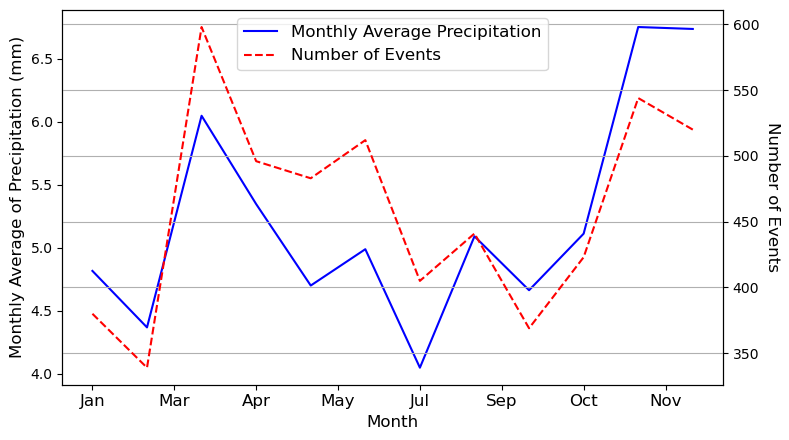

In [107]:
# Merge the two DataFrames on 'Month'
merged_data = pd.merge(monthly_average, events_per_month, on='Month', how='inner')

# Mapping months to their names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Replace month numbers with month names
merged_data['Month'] = merged_data['Month'].apply(lambda x: month_names[int(x) - 1])

# Extract months, rainfall (rr), and event numbers (events_count)
months = merged_data['Month'].tolist()
rainfall = merged_data['rr'].tolist()  # From monthly_average
event_numbers = merged_data['events_count'].tolist()  # From event_per_month

# Creating the figure
fig, ax1 = plt.subplots(figsize=(8,5))

# Plot rainfall data
ax1.plot(months, rainfall, label='Monthly Average Precipitation', color='blue')

# Creating the secondary y-axis for event numbers
ax2 = ax1.twinx()
ax2.plot(months, event_numbers, color='red', linestyle='--', label='Number of Events')

# Set labels and title
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Monthly Average of Precipitation (mm)', fontsize=12)
ax2.set_ylabel('Number of Events', fontsize=12, rotation=270, labelpad=15)

# Set x-axis tick size and increase the number of month ticks
ax1.tick_params(axis='x', labelsize=12)
ax1.xaxis.set_major_locator(MaxNLocator(nbins=12))  # 12 months

# Adding legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper center', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Show plot
fig = plt.gcf()
plt.grid()
fig.tight_layout(rect=[0.5, 0.5, 1.5, 1.4])
plt.show()

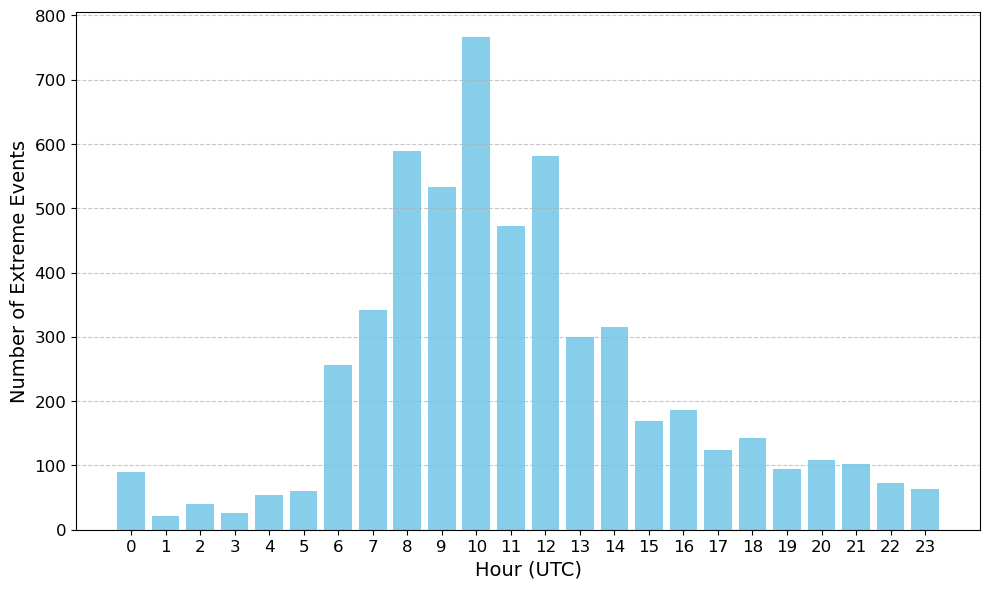

In [108]:
# Ensure the data is sorted by hour (just in case)
hourly_event_count = hourly_event_count.sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(hourly_event_count.index, hourly_event_count.values, color='skyblue')  # Use values for the y-axis

# Set labels and title
plt.xlabel('Hour (UTC)', fontsize=14)
plt.ylabel('Number of Extreme Events', fontsize=14)
#plt.title('Hourly Count of Extreme Events (2015-2023)', fontsize=20)

# Adjust x-tick and y-tick sizes
plt.xticks(range(24), fontsize=12)
plt.yticks(fontsize=12)

# Add a grid to the y-axis
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()